In [ ]:
# Loan Risk Analysis – Exploratory Data Analysis (EDA)

## Objective
The goal of this notebook is to analyze loan performance and identify risk patterns.

We focus only on completed loans:
- Fully Paid
- Charged Off

Key business questions:
1. How does default rate vary by grade?
2. Is interest rate compensating for default risk?
3. Does income impact default probability?
4. Does DTI impact risk?
5. Are there geographic or time-based patterns?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [3]:
df = pd.read_csv(r"C:\Users\lalit\Downloads\Loan project\data\Processed\loan_raw.csv", low_memory=False)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [ ]:
## Loan Status Distribution

Before filtering, let's understand overall loan status distribution.


In [5]:
(df['loan_status'].value_counts(normalize=True) * 100).round(2)


loan_status
Fully Paid                                             47.63
Current                                                38.85
Charged Off                                            11.88
Late (31-120 days)                                      0.95
In Grace Period                                         0.37
Late (16-30 days)                                       0.19
Does not meet the credit policy. Status:Fully Paid      0.09
Does not meet the credit policy. Status:Charged Off     0.03
Default                                                 0.00
Name: proportion, dtype: float64

In [ ]:
For meaningful default analysis, we consider only:

- Fully Paid
- Charged Off


In [9]:
df_closed = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

(df_closed['loan_status'].value_counts(normalize=True) * 100).round(2)


loan_status
Fully Paid     80.04
Charged Off    19.96
Name: proportion, dtype: float64

In [ ]:
## Default Rate by Grade

Higher grades (A) should have lower risk.
Lower grades (G) should have higher risk.
Let's verify.


In [10]:
grade_risk = (
    pd.crosstab(
        df_closed['grade'],
        df_closed['loan_status'],
        normalize='index'
    ) * 100
).round(2)

grade_risk


loan_status,Charged Off,Fully Paid
grade,,
A,6.04,93.96
B,13.39,86.61
C,22.44,77.56
D,30.38,69.62
E,38.48,61.52
F,45.20,54.80
G,49.93,50.07


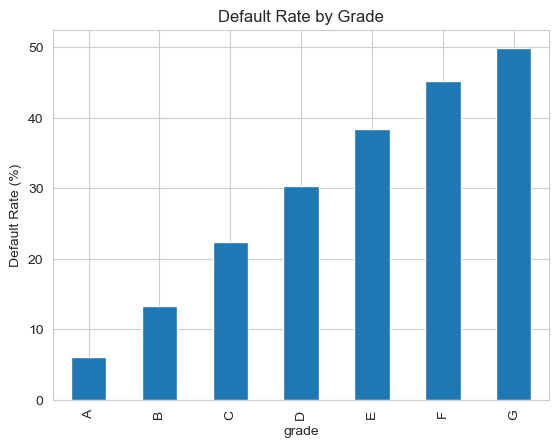

In [11]:
grade_risk['Charged Off'].plot(kind='bar')
plt.title("Default Rate by Grade")
plt.ylabel("Default Rate (%)")
plt.show()


In [ ]:
## Interest Rate vs Default Rate

We test whether higher interest rates compensate for higher default risk.


In [12]:
summary = (
    df_closed
    .groupby('grade')
    .agg(
        default_rate=('loan_status', lambda x: (x=='Charged Off').mean()),
        avg_int_rate=('int_rate','mean')
    )
)

summary['expected_return'] = (
    summary['avg_int_rate'] - summary['default_rate']*100
)

summary.round(2)


,default_rate,avg_int_rate,expected_return
grade,,,
A,0.06,7.11,1.07
B,0.13,10.68,-2.71
C,0.22,14.02,-8.42
D,0.30,17.72,-12.66
E,0.38,21.14,-17.34
F,0.45,24.93,-20.27
G,0.50,27.73,-22.21


In [ ]:
## Income Segmentation (Quantile Based)

We divide borrowers into 5 equal income groups.


In [13]:
df_closed['income_bucket'] = pd.qcut(
    df_closed['annual_inc'],
    5,
    labels=['Very Low','Low','Medium','High','Very High']
)

income_risk = (
    pd.crosstab(
        df_closed['income_bucket'],
        df_closed['loan_status'],
        normalize='index'
    ) * 100
).round(2)

income_risk


loan_status,Charged Off,Fully Paid
income_bucket,,
Very Low,23.48,76.52
Low,21.60,78.40
Medium,20.31,79.69
High,18.44,81.56
Very High,15.72,84.28


In [ ]:
## Debt-to-Income (DTI) Risk Analysis

Higher DTI indicates higher financial stress.


In [14]:
df_closed['dti_bucket'] = pd.cut(
    df_closed['dti'],
    bins=[0,10,20,30,40,50,100],
    labels=['DTI_0_10','DTI_10_20','DTI_20_30','DTI_30_40','DTI_40_50','DTI_50_plus']
)

dti_risk = (
    pd.crosstab(
        df_closed['dti_bucket'],
        df_closed['loan_status'],
        normalize='index'
    ) * 100
).round(2)

dti_risk


loan_status,Charged Off,Fully Paid
dti_bucket,,
DTI_0_10,14.87,85.13
DTI_10_20,17.84,82.16
DTI_20_30,23.05,76.95
DTI_30_40,29.10,70.90
DTI_40_50,31.86,68.14
DTI_50_plus,29.09,70.91


In [ ]:
## State-wise Default Risk

To avoid misleading results, we filter states with sufficient loan volume.


In [15]:
state_counts = df_closed['addr_state'].value_counts()

valid_states = state_counts[state_counts > 1000].index

state_risk = (
    df_closed[df_closed['addr_state'].isin(valid_states)]
    .groupby('addr_state')['loan_status']
    .apply(lambda x: (x=='Charged Off').mean()*100)
    .sort_values(ascending=False)
)

state_risk.head(10)


addr_state
MS    26.077717
NE    25.181260
AR    24.086792
AL    23.632095
OK    23.475287
LA    23.182141
NY    22.043481
NV    21.922337
FL    21.474594
IN    21.408178
Name: loan_status, dtype: float64

In [ ]:
## Default Rate Over Time


In [16]:
df_closed['issue_year'] = pd.to_datetime(
    df_closed['issue_d'],
    format='%b-%Y'
).dt.year

year_risk = (
    df_closed.groupby('issue_year')['loan_status']
    .apply(lambda x: (x=='Charged Off').mean()*100)
)

year_risk.sort_index()


issue_year
2007    17.928287
2008    15.813060
2009    12.595420
2010    12.890083
2011    15.178859
2012    16.197275
2013    15.595976
2014    18.449409
2015    20.184798
2016    23.283236
2017    23.123449
2018    15.746479
Name: loan_status, dtype: float64

In [18]:
## Saving the final dataset for SQL & Dashboard

df_closed.to_csv(r"C:\Users\lalit\Downloads\Loan project\data\Processed/loan_final_dataset.csv", index=False)